In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf 
from keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [2]:
from utils import join_data, train_test,hervy_dist

In [3]:
dst_folder = "C:\\Users\\Reset me please\\Desktop\\PMI\\Processed_Data1\\"

In [4]:
df = join_data(dst_folder)

In [5]:
X_train, X_test, y_train, y_test = train_test(df, 0.1)

In [6]:
# y_train =y_train.reindex(columns=["Longitude_1","Latitude_1"])
# y_test =y_test.reindex(columns=["Longitude_1","Latitude_1"])

In [7]:
RADIUS_KM = 6378.1

def degrees_to_radians(deg):
    pi_on_180 = 0.017453292519943295
    return deg * pi_on_180

def loss_haversine(observation, prediction):
    # print(observation)
    obv_rad = tf.map_fn(degrees_to_radians, observation)
    prev_rad = tf.map_fn(degrees_to_radians, prediction)

    dlon_dlat = obv_rad - prev_rad 
    v = dlon_dlat / 2
    v = tf.sin(v)
    v = v**2

    a = v[:,1] + tf.cos(obv_rad[:,1]) * tf.cos(prev_rad[:,1]) * v[:,0] 

    c = tf.sqrt(a)
    c = 2* tf.math.asin(c)
    c = c*RADIUS_KM
    final = tf.reduce_sum(c)

    #if you're interested in having MAE with the haversine distance in KM
    #uncomment the following line
#     final = final/tf.dtypes.cast(tf.shape(observation)[0], dtype= tf.float32)

    return final

In [8]:
def get_model(n_inputs, n_outputs, dropout_rate,training):    
    inputs = tf.keras.layers.Input(shape=(n_inputs,))
    # x = tf.keras.layers.Dropout(rate=dropout_rate)(inputs, training=training)
    x = tf.keras.layers.Dense(units=5, activation='relu')(inputs)
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(x, training=training)  
    x = tf.keras.layers.Dense(units=5, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x, training=training)
    x = tf.keras.layers.Dense(units=2, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam',
#                       loss=loss_haversine)
    optimizer = tf.keras.optimizers.Adam(learning_rate=.00001)
    model.compile(optimizer=optimizer,
                      loss=loss_haversine)
    return model

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=.1,
                              patience=4, min_lr=0.0000000000000000000001, min_delta=100)

In [11]:
model = get_model(X_train.shape[1],  y_train.shape[1],.1, True)

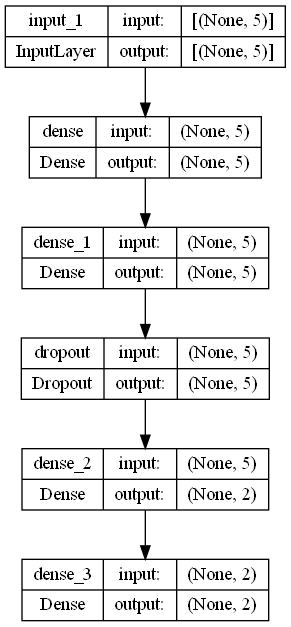

In [12]:

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
model.fit(X_train,y_train,epochs=400,batch_size=500, verbose=1,callbacks=[reduce_lr])

Epoch 1/400
822/822 [==============================] - 303s 367ms/step - loss: 6403441.0000 - lr: 1.0000e-05
Epoch 2/400
822/822 [==============================] - 308s 374ms/step - loss: 6402466.5000 - lr: 1.0000e-05
Epoch 3/400
822/822 [==============================] - 304s 370ms/step - loss: 6401694.0000 - lr: 1.0000e-05
Epoch 4/400
822/822 [==============================] - 282s 343ms/step - loss: 6401025.5000 - lr: 1.0000e-05
Epoch 5/400
822/822 [==============================] - 307s 374ms/step - loss: 6400372.5000 - lr: 1.0000e-05
Epoch 6/400
822/822 [==============================] - 307s 373ms/step - loss: 6399747.5000 - lr: 1.0000e-05
Epoch 7/400
822/822 [==============================] - 305s 371ms/step - loss: 6399150.5000 - lr: 1.0000e-05
Epoch 8/400
822/822 [==============================] - 306s 372ms/step - loss: 6398572.5000 - lr: 1.0000e-05
Epoch 9/400
822/822 [==============================] - 302s 368ms/step - loss: 6397988.5000 - lr: 1.0000e-05
Epoch 10/400
822/82

KeyboardInterrupt: 

In [ ]:
model.save("bayesian_model")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_pred = model.predict(X_test)
hervy_dist(y_pred, y_test)["Distance"].mean()